<h2>Stock price prediction</h2> 

* I used 'Vytautas Bielinskas's code as my baseline. 2020.

* Modified and upraded version done by HyunJun Lee. 2021

In [ ]:
# yahoo finance Api
%pip install yfinance
% pip install yahoo-finance
%pip install yahoo_fin
%pip install requests_html

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<h3>1. Read data</h3>

- FED FUNDS data source: https://fred.stlouisfed.org/series/FEDFUNDS
- Stock data source is from yahoofinance Api

In [3]:
# Import modules and packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
%matplotlib inline
import yfinance as yf
import matplotlib.pyplot as plt
# FED FUNDS add
ff = pd.read_excel("/content/drive/MyDrive/excel/FEDFUNDS.xlsx")
yf.pdr_override()

# company_cd=input()
company_cd = 'AMKR'

# Training data set
df=yf.download(company_cd)
df = df.reset_index()

[*********************100%***********************]  1 of 1 completed


Data concatnation and preprocessing

In [4]:
ff['Date_ff']=ff['Date_ff']//100

df['Date_ff']=df["Date"]
df_date = df['Date_ff']
df['Date_ff'] = pd.to_datetime(df['Date_ff']).astype(str)
df['Date_ff']=df['Date_ff'].replace('-',"")

for i in range(len(df['Date_ff'])):
  df['Date_ff'][i]=df['Date_ff'][i].replace('-',"")
df['Date_ff'] = df['Date_ff'].astype(int)//100
df = pd.merge(df, ff, how = "left", on = ["Date_ff"])
df.drop(["Date_ff"], axis = 1, inplace = True)
df.drop(["Adj Close"], axis = 1, inplace = True)

df = df.fillna(0.08)
df.reset_index(drop = True, inplace = True)
df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,Date,Open,High,Low,Close,Volume,FEDFUNDS
0,1998-05-01,12.375000,13.562500,11.750000,13.312500,23597300,5.49
1,1998-05-04,13.437500,14.000000,13.375000,13.750000,3529400,5.49
2,1998-05-05,13.750000,13.875000,13.000000,13.250000,3056300,5.49
3,1998-05-06,13.250000,13.250000,11.875000,12.625000,3109900,5.49
4,1998-05-07,12.625000,12.750000,12.250000,12.312500,1304100,5.49
...,...,...,...,...,...,...,...
5920,2021-11-08,23.680000,24.139999,23.639999,23.790001,893200,0.08
5921,2021-11-09,23.889999,23.930000,23.150000,23.520000,752500,0.08
5922,2021-11-10,23.090000,23.450001,22.590000,22.690001,685300,0.08
5923,2021-11-11,23.100000,23.260000,22.860001,23.100000,461500,0.08


<h3>2. Data pre-processing and data extraction</h3>


<h3> Feature extraction </h3>

- As you see 'Open', 'High', 'Low', 'Close' there correlation is over 99% which means they are not useful as features.
- However 'FED FUNDS's correlation is over than 40% which is pretty high can be used as features.

In [6]:
check = df
check.reset_index(drop = True, inplace = True)
check.corr()

,Open,High,Low,Close,Volume,FEDFUNDS
Open,1.000000,0.998596,0.998444,0.997151,-0.087078,0.421182
High,0.998596,1.000000,0.998023,0.998790,-0.080058,0.427061
Low,0.998444,0.998023,1.000000,0.998505,-0.093284,0.414198
Close,0.997151,0.998790,0.998505,1.000000,-0.085572,0.420577
Volume,-0.087078,-0.080058,-0.093284,-0.085572,1.000000,0.089650
FEDFUNDS,0.421182,0.427061,0.414198,0.420577,0.089650,1.000000


In [7]:
# drop unuseful columns
dataset_train =df
dataset_train.drop(["High", "Low", "Open", "Volume"], axis = 1, inplace = True)

In [8]:
# Select features (columns) to be involved intro training and predictions
cols = list(dataset_train)[1:3]

# Extract dates (will be used in visualization)
datelist_train = pd.to_datetime(dataset_train['Date'])
datelist_train = list(map(str, dataset_train['Date']))
for i in range(len(datelist_train)):
  datelist_train[i]=datelist_train[i][:10]

datelist_train = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in datelist_train]


In [9]:
print('Training set shape == {}'.format(dataset_train.shape))
print('All timestamps == {}'.format(len(datelist_train)))
print('Featured selected: {}'.format(cols))

Training set shape == (5925, 3)
All timestamps == 5925
Featured selected: ['Close', 'FEDFUNDS']


<h3> Mutivariable LSTM model</h3>

- Add external data 'FED FUNDS'
- Stock 'Closed' dataset


In [10]:
# Scaling
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Import Libraries and packages from Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from tensorflow.keras.optimizers import Adam # - Works
from keras.layers import Bidirectional

In [11]:
dataset_train = dataset_train[cols].astype(str)
for i in cols:
    for j in range(0, len(dataset_train)):
        dataset_train[i][j] = dataset_train[i][j].replace(',', '')

dataset_train = dataset_train.astype(float)

In [12]:
dataset_train

,Close,FEDFUNDS
0,13.312500,5.49
1,13.750000,5.49
2,13.250000,5.49
3,12.625000,5.49
4,12.312500,5.49
...,...,...
5920,23.790001,0.08
5921,23.520000,0.08
5922,22.690001,0.08
5923,23.100000,0.08


In [13]:
# Using multiple features (predictors)
data_set = dataset_train.to_numpy()

print('Shape of training set == {}.'.format(data_set.shape))
# MinMaxScaler
sc = MinMaxScaler()
training_set_scaled = sc.fit_transform(data_set)

sc_predict = MinMaxScaler()
sc_predict.fit_transform(data_set[:, 0:1])

# sc_df = scaling_df(dataset_train)

# training_set_scaled

Shape of training set == (5925, 2).


array([[0.19116196],
       [0.19806668],
       [0.19017558],
       ...,
       [0.33915961],
       [0.34563031],
       [0.34878673]])

In [14]:
n_future = 20   # Number of days we want top predict into the future
n_past = 60     # Number of past days we want to use to predict the future
X_train = []
y_train = []


for i in range(n_past, len(training_set_scaled) +1):
    X_train.append(training_set_scaled[i - n_past:i, 0:dataset_train.shape[1] - 1])
    y_train.append(training_set_scaled[i  - 1:i , 0])
    # y_train.append(training_set_scaled[i + n_future - 1:i + n_future, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

X_train shape == (5866, 60, 1).
y_train shape == (5866, 1).


In [15]:
############TRAIN, VALIDATE
X_train1, X_test1 = train_test_split(X_train, test_size=0.2, random_state=0, shuffle=False)
y_train1, y_test1 = train_test_split(y_train, test_size=0.2, random_state=0, shuffle=False)
X_train_dt, y_test_dt = train_test_split(datelist_train, test_size=0.2, random_state=0, shuffle=False)


<h3>3. Building the LSTM based Neural Network</h3>

<h3>LSTM model must be 3D</h3>

* (batch_size, time_steps, units)
* use past day as prediction

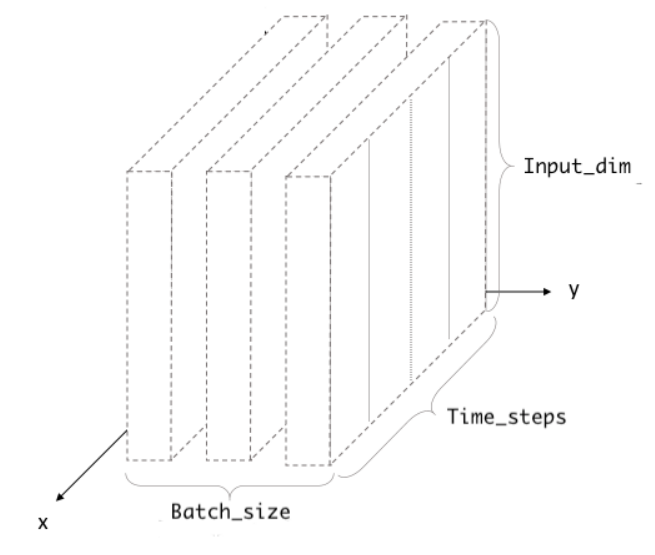

In [16]:
n_past, dataset_train.shape[1]-1

(60, 1)

<h3>model input: [data_size, time_steps, features] </h3>

- <b>data_size</b>: As you added the train data you don't need additional information of data_size.
- <b>time_stemps</b>: You use 60 days of patterns to predict 20 days so time_steps are 60
- <b>features</b>: As I used 2 features 'Closed' and 'FED FUNDS'.

 However I used 'Closed' as a prediction target so features are df.shape[1]-1.

 Which is 2 -1 = 1 in this code.

In [17]:
# Initializing the Neural Network based on LSTM
model1 = Sequential()

# Adding 1st Bidirectional LSTM layer
model1.add(Bidirectional(LSTM(128, return_sequences = True), input_shape = (n_past, dataset_train.shape[1]-1)))

# Adding 2nd LSTM layer
model1.add(LSTM(units=100, return_sequences=False))

# Adding Dropout
model1.add(Dropout(0.5))

# Output layer
model1.add(Dense(units=1, activation='linear'))

# Compiling the Neural Network
model1.compile(optimizer = Adam(learning_rate=0.01), loss='mean_squared_error')

es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

history = model1.fit(X_train, y_train, shuffle=True, epochs=100, callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose=1, batch_size=256)


Epoch 1/100
19/19 [==============================] - ETA: 0s - loss: 0.0313
Epoch 00001: val_loss improved from inf to 0.00780, saving model to weights.h5
19/19 [==============================] - 21s 818ms/step - loss: 0.0313 - val_loss: 0.0078 - lr: 0.0100
Epoch 2/100
19/19 [==============================] - ETA: 0s - loss: 0.0065
Epoch 00002: val_loss improved from 0.00780 to 0.00011, saving model to weights.h5
19/19 [==============================] - 14s 752ms/step - loss: 0.0065 - val_loss: 1.0568e-04 - lr: 0.0100
Epoch 3/100
19/19 [==============================] - ETA: 0s - loss: 9.4318e-04
Epoch 00003: val_loss improved from 0.00011 to 0.00009, saving model to weights.h5
19/19 [==============================] - 14s 757ms/step - loss: 9.4318e-04 - val_loss: 8.7927e-05 - lr: 0.0100
Epoch 4/100
19/19 [==============================] - ETA: 0s - loss: 7.1516e-04
Epoch 00004: val_loss improved from 0.00009 to 0.00009, saving model to weights.h5
19/19 [==============================] 

<p>
Notes:<br>
<ul>
<li><b>EarlyStopping</b> - Stop training when a monitored metric has stopped improving.</li>
<li><code>monitor</code> - quantity to be monitored.</li>
<li><code>min_delta</code> - minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than <code>min_delta</code>, will count as no improvement.</li>
<li><code>patience</code> - number of epochs with no improvement after which training will be stopped.</li>
</ul>

<ul>
<li><b>ReduceLROnPlateau</b> - Reduce learning rate when a metric has stopped improving.</li>
<li><code>factor</code> - factor by which the learning rate will be reduced. <code>new_lr = lr * factor</code>.</li>
</ul>
</p>

<hr>


<!-- <p>
We will perform predictions for the next <b>20</b> days, since <b>2020-07-10</b> to <b>today +20</b>.
</p> -->

# Generate list of sequence of days for predictions
datelist_future = pd.date_range(datelist_train[-1], periods=n_future, freq='1d').tolist()

'''
Remeber, we have datelist_train from begining.
'''

# Convert Pandas Timestamp to Datetime object (for transformation) --> FUTURE
datelist_future_ = []
for this_timestamp in datelist_future:
    datelist_future_.append(this_timestamp.date())

<h3>4. Make predictions for future dates</h3>

In [21]:
# Generate list of sequence of days for predictions
datelist_future = pd.date_range(datelist_train[-1], periods=n_future, freq='1d').tolist()

'''
Remeber, we have datelist_train from begining.
'''

# Convert Pandas Timestamp to Datetime object (for transformation) --> FUTURE
datelist_future_ = []
for this_timestamp in datelist_future:
    datelist_future_.append(this_timestamp.date())

In [18]:
# Perform predictions
def prediction(data):
  predictions_future = model1.predict(data[-n_future:]) # predict next 20days
  predictions_train = model1.predict(data[n_past:])
  return predictions_future, predictions_train

pre = prediction(X_train)

predictions_future = pre[0]
predictions_train = pre[1]

In [19]:
print(len(dataset_train))
print(len(predictions_train))
print(len(predictions_future))

5925
5806
20


In [22]:
#Inverse the predictions to original measurements

# ---> Special function: convert <datetime.date> to <Timestamp>
def datetime_to_timestamp(x):
    '''
        x : a given datetime value (datetime.date)
    '''
    return dt.datetime.strptime(x.strftime('%Y%m%d'), '%Y%m%d')


y_pred_future = sc_predict.inverse_transform(predictions_future)
y_pred_train = sc_predict.inverse_transform(predictions_train)

PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['Close']).set_index(pd.Series(datelist_future))
PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=['Close']).set_index(pd.Series(datelist_train[2 * n_past -1:]))

# Convert <datetime.date> to <Timestamp> for PREDCITION_TRAIN
PREDICTION_TRAIN.index = PREDICTION_TRAIN.index.to_series().apply(datetime_to_timestamp)

PREDICTION_TRAIN.tail(3)

,Close
2021-11-10,23.133490
2021-11-11,23.035213
2021-11-12,23.088938


<h3>5. Visualizing Predictions</h3>

In [23]:
# Parse training set timestamp for better visualization
dataset_train = pd.DataFrame(dataset_train, columns=cols)
dataset_train.index = datelist_train
dataset_train.index = pd.to_datetime(dataset_train.index)

In [24]:
# Balance the diffrence
diffrence = dataset_train['Close'][-1] - PREDICTIONS_FUTURE['Close'][0]
PREDICTIONS_FUTURE= PREDICTIONS_FUTURE.apply(lambda x: x+diffrence)

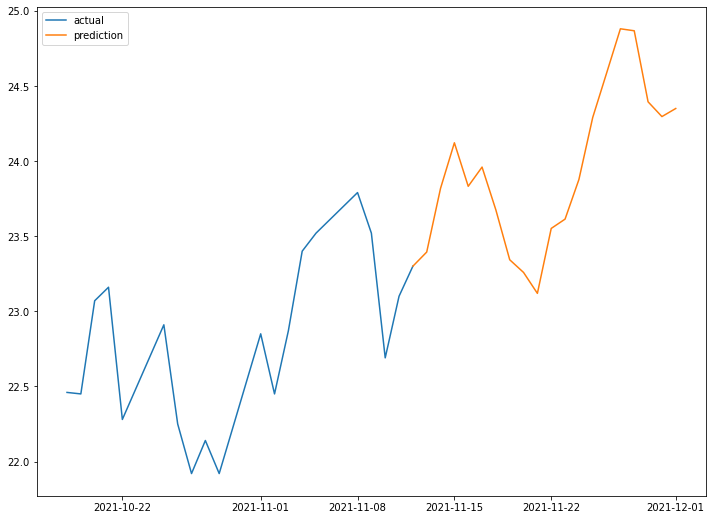

In [25]:
plt.figure(figsize=(12, 9))
plt.plot(dataset_train['Close'][len(dataset_train)-20:], label='actual')
plt.plot(PREDICTIONS_FUTURE['Close'], label='prediction')
plt.legend()
plt.show()

In [26]:
dataset_train.tail(2)

,Close,FEDFUNDS
2021-11-11,23.100000,0.08
2021-11-12,23.299999,0.08


20
20


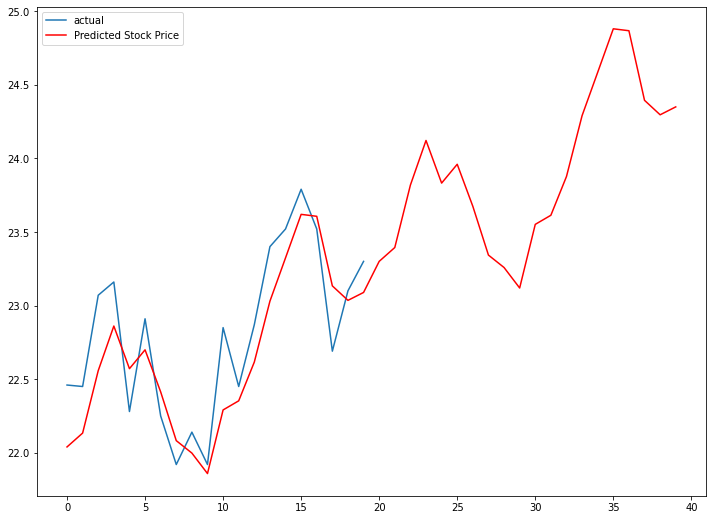

In [27]:
a= np.asarray(PREDICTION_TRAIN['Close'])[-20:]
b = np.asarray(PREDICTIONS_FUTURE['Close'])
print(len(a))
print(len(b))

a = np.concatenate((a, b))
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(dataset_train['Close'])[-20:], label='actual')
plt.plot(a, color='r', label='Predicted Stock Price')
plt.legend()
plt.show()

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


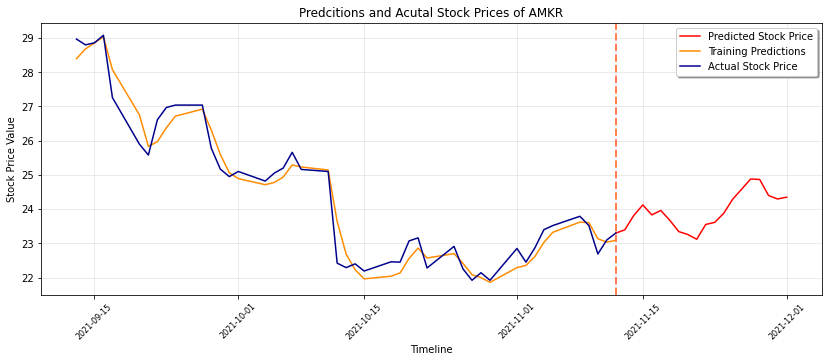

In [28]:
# Set plot size 
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5

# Plot parameters
START_DATE_FOR_PLOTTING = '2021-02-20'
START_DATE_FOR_PLOTTING_ACTUAL = '2021-09-11'
plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['Close'], color='r', label='Predicted Stock Price')
plt.plot(PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING_ACTUAL:].index, PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING_ACTUAL:]['Close'], color='darkorange', label='Training Predictions')
plt.plot(dataset_train.loc[START_DATE_FOR_PLOTTING_ACTUAL:].index, dataset_train.loc[START_DATE_FOR_PLOTTING_ACTUAL:]['Close'], color='darkblue', label='Actual Stock Price')
plt.axvline(x = min(PREDICTIONS_FUTURE.index), color='coral', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Predcitions and Acutal Stock Prices of '+ company_cd, family='Arial', fontsize=12)
plt.xlabel('Timeline', family='Arial', fontsize=10)
plt.ylabel('Stock Price Value', family='Arial', fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.show()

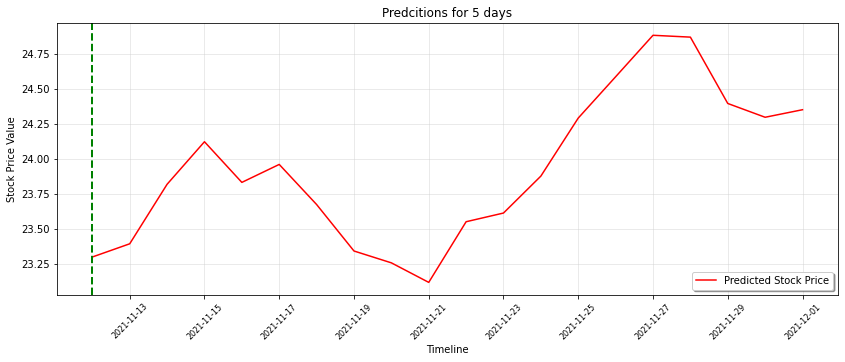

In [29]:
plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['Close'], color='r', label='Predicted Stock Price')
plt.axvline(x = min(PREDICTIONS_FUTURE.index), color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Predcitions for 5 days', family='Arial', fontsize=12)
plt.xlabel('Timeline', family='Arial', fontsize=10)
plt.ylabel('Stock Price Value', family='Arial', fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.show()

In [30]:
PREDICTIONS_FUTURE

,Close
2021-11-12,23.299999
2021-11-13,23.394125
2021-11-14,23.818220
2021-11-15,24.121328
2021-11-16,23.831701
2021-11-17,23.959667
2021-11-18,23.674030
2021-11-19,23.342770
2021-11-20,23.258341
2021-11-21,23.119165


<h3>7. Evaluating the model</h3>

In [31]:
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_absolute_error

MSE = mean_squared_error(np.asarray(PREDICTION_TRAIN['Close'])[-20:], np.asarray(dataset_train['Close'])[-20:]) 
print('MSE: ', np.sqrt(MSE))
MAE = mean_absolute_error(np.asarray(PREDICTION_TRAIN['Close'])[-20:], np.asarray(dataset_train['Close'])[-20:])

print('MAE: ', MAE)

MSE:  0.289789512887546
MAE:  0.2516506195068359


<h2>Stock & Economy Study </h2>

<h4>EPS(Earning Per Share)=(company's net income)/(total shares)
</h4>
ex) A company's net income 2million won,10000 stocks issuance: A company's EPS= 2million won / 10000= 20000 won-> 1 stock for 20000 won
<br>
<br>
<h4>PER(Price Earning Ratio)=(current stock price)/EPS</h4>
ex) A stock price: 200000 won: A company's PER= 200000/20000=10(times)

<br> 

<h4>BPS(Book-value Per Share:주당순자산가치)</h4>
ex) A company's BPS = 8 million won / 10000 = 80000 won
<br> <br>
<h4>PBR(Price Book-value Ratio: 주가 순자산비율) </h4>
ex) PBR = (currend stock price / (current BPS)

<h2>How to find good stocks by checking ROE! </h2>
<br>
1. The reason ROE is important from an investor's point of view is that it is easy to determine how much return a company can earn with its investment.
<br>
ex) 

Company A said that it would make an annual profit of 100 million won with an investment of 1 billion won. If company B makes a profit of 200 million won with the same investment, people will invest more in company B. Because I can earn more with my investment

In [32]:
from yahoo_fin.stock_info import get_analysts_info
from yahoo_fin.stock_info import *
get_analysts_info('AMKR')

{'EPS Revisions':        EPS Revisions  ...  Next Year (2022)
 0     Up Last 7 Days  ...               NaN
 1    Up Last 30 Days  ...               1.0
 2   Down Last 7 Days  ...               NaN
 3  Down Last 30 Days  ...               NaN
 
 [4 rows x 5 columns], 'EPS Trend':           EPS Trend  ...  Next Year (2022)
 0  Current Estimate  ...              2.45
 1        7 Days Ago  ...              2.45
 2       30 Days Ago  ...              2.45
 3       60 Days Ago  ...              2.60
 4       90 Days Ago  ...              2.60
 
 [5 rows x 5 columns], 'Earnings Estimate':   Earnings Estimate  ...  Next Year (2022)
 0   No. of Analysts  ...              1.00
 1     Avg. Estimate  ...              2.45
 2      Low Estimate  ...              2.45
 3     High Estimate  ...              2.45
 4      Year Ago EPS  ...              2.40
 
 [5 rows x 5 columns], 'Earnings History':   Earnings History 6/29/2020 9/29/2020 12/30/2020 3/30/2021
 0         EPS Est.     -0.03      0.31    

In [33]:
get_balance_sheet('AMKR', yearly = False)

endDate,2021-09-30,2021-06-30,2021-03-31,2020-12-31
Breakdown,,,,
capitalSurplus,1.973207e+09,1.968339e+09,1.964331e+09,1.953378e+09
totalLiab,3.010769e+09,2.984709e+09,2.591228e+09,2.668352e+09
totalStockholderEquity,2.730013e+09,2.554248e+09,2.433917e+09,2.325699e+09
minorityInterest,2.966600e+07,2.882200e+07,2.832000e+07,2.826000e+07
otherCurrentLiab,4.968310e+08,5.564660e+08,3.523070e+08,2.382100e+08
totalAssets,5.770448e+09,5.567779e+09,5.053465e+09,5.022311e+09
commonStock,2.900000e+05,2.900000e+05,2.900000e+05,2.890000e+05
otherCurrentAssets,4.952700e+07,4.662100e+07,4.252700e+07,4.122500e+07
retainedEarnings,9.596410e+08,7.885670e+08,6.725340e+08,5.625020e+08


In [34]:
get_cash_flow('AMKR', yearly = False)

endDate,2021-09-30,2021-06-30,2021-03-31,2020-12-31
Breakdown,,,,
investments,-88168000.0,4456000.0,-29251000.0,222575000.0
changeToLiabilities,0.0,0.0,0.0,48786000.0
totalCashflowsFromInvestingActivities,-314874000.0,-157123000.0,-164372000.0,-27368000.0
netBorrowings,-30512000.0,-39581000.0,-37024000.0,-187047000.0
totalCashFromFinancingActivities,-39109000.0,-48095000.0,-49444000.0,-180557000.0
changeToOperatingActivities,-174455000.0,15549000.0,-80991000.0,217526000.0
netIncome,180854000.0,125806000.0,119809000.0,126674000.0
changeInCash,-179191000.0,74448000.0,-47425000.0,131420000.0
effectOfExchangeRate,-496000.0,123000.0,-10397000.0,3360000.0
